In [1]:
import pandas as pd
import pylab as plt
import os
from glob import glob
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
     
gnd_fname = glob('pipeline_data/data_????-??-??.csv')[0]
df_gnd = pd.read_csv(gnd_fname, dtype={'fips': str}).set_index('fips')

## Functions

In [3]:
def get_plot_data(target_type, method):
    data = {}
    for i in range(len(steps)):
        gnd = df_gnd[f'{target_type}{i}'].sum()
        gnd_date = steps[i]

        if gnd_date in data:
            data[gnd_date]['gnd'] = gnd
        else:
            data[gnd_date] = {'gnd': gnd}

        prd_fname = f'results_time/{steps[i]}_{target_type}_method-{method}.csv'
        if os.path.isfile(prd_fname):
            df_forecast = pd.read_csv(prd_fname)
            df_forecast_nation = df_forecast[df_forecast.location=='US']
            target_end_dates = df_forecast_nation['target_end_date'].unique()


            for d in target_end_dates:
                tmp = df_forecast_nation[df_forecast_nation.target_end_date == d]
                horizon = int(tmp['target'].values[0].split(' ')[0])

                point = tmp[tmp['type'] == 'point']['value'].values[0]

                if d in data:
                    data[d][f'prd_{horizon}'] = point
                else:
                    data[d] = {f'prd_{horizon}': point}
    
    return pd.DataFrame(data=data).T

In [4]:
def plot_and_save(target_type):

    methods = [0, 1]
    fig, axes = plt.subplots(len(methods), 1, figsize=(12, 7), sharex=True)

    dfs  = []
    for method in methods:
        df = get_plot_data(target_type=target_type, method=method)
        col_map = {'gnd': f'gnd-{method}', 'prd_1': f'prd-{method}_1', 'prd_2': f'prd-{method}_2'}
        df = df[['gnd', 'prd_1', 'prd_2']].rename(columns=col_map)
        dfs.append(df)
        ax = axes[method]
        df.plot(ax=ax, marker='o')
        ax.set_xticks(range(len(steps)))
        ax.set_xticklabels(steps)
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'method {method}', fontsize=25)

    df_compare = pd.concat(dfs, axis=1)\
        .drop([f'gnd-{m}' for m in methods[1:]], axis=1)\
        .rename(columns={f'gnd-{methods[0]}': 'gnd'})
    df_compare.to_csv(f'results_time/methodCompare_{target_type}_ours.csv', float_format='%.0f')

## Case

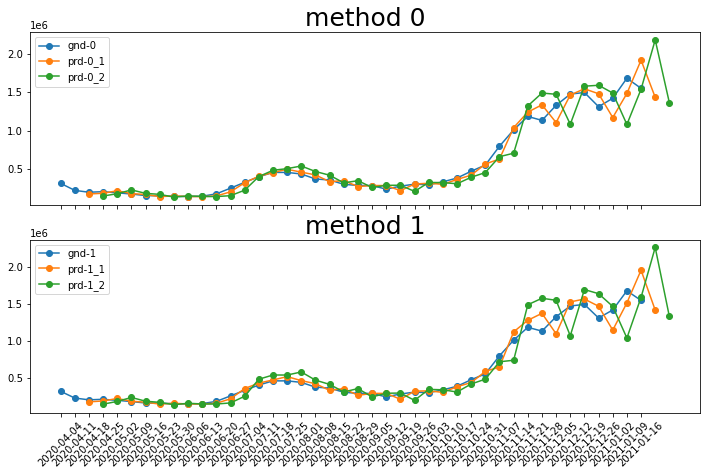

In [5]:
target_type = 'case'
plot_and_save(target_type)

## Death

In [7]:
# target_type = 'death'
# plot_and_save(target_type)